Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points)

In [24]:
import numpy as np
from neurodynex3.hopfield_network import plot_tools
from tensorflow.keras.datasets import mnist
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [25]:
# Helper function for the Hopfield network
def calculate_weights(patterns):
    num_neurons = patterns[0].size
    weights = np.zeros((num_neurons, num_neurons))
    for p in patterns:
        p = p.flatten()
        weights += np.outer(p, p)
    np.fill_diagonal(weights, 0)
    return weights / len(patterns)

def recall_pattern(weights, pattern, steps=10):
    pattern = pattern.flatten()
    for _ in range(steps):
        pattern = np.sign(np.dot(weights, pattern))
    return pattern.reshape((int(np.sqrt(pattern.size)), int(np.sqrt(pattern.size))))

def mnist_to_binary_patterns(pattern_size, num_samples, threshold=127):
    (x_train, y_train), _ = mnist.load_data()
    patterns = []
    labels = []
    for i in range(num_samples):
        image = x_train[i]
        resized_image = np.array(Image.fromarray(image).resize((pattern_size, pattern_size)))
        binary_pattern = (resized_image > threshold).astype(int)
        binary_pattern[binary_pattern == 0] = -1
        patterns.append(binary_pattern)
        labels.append(y_train[i])
    return np.array(patterns), np.array(labels)

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

In [26]:
# Step 2: Prepare MNIST data
pattern_size = 14
num_samples = 1000
patterns, labels = mnist_to_binary_patterns(pattern_size, num_samples)

# Split data into training and test sets
train_patterns, test_patterns, train_labels, test_labels = train_test_split(patterns, labels, test_size=0.2, random_state=42)

In [27]:
# Step 3: Train Hopfield Network
unique_labels = np.unique(train_labels)
class_patterns = []
for label in unique_labels:
    label_patterns = train_patterns[train_labels == label]
    class_patterns.append(label_patterns.mean(axis=0))

weights = calculate_weights(class_patterns)

In [28]:
# Step 4: Classify using Hopfield Network
predicted_labels_hopfield = []
for i in range(len(test_patterns)):
    recalled_pattern = recall_pattern(weights, test_patterns[i])
    similarities = [np.sum(recalled_pattern == p) for p in class_patterns]
    predicted_labels_hopfield.append(unique_labels[np.argmax(similarities)])

In [29]:
# Step 5: Calculate F-score for Hopfield Network
f_score_hopfield = f1_score(test_labels, predicted_labels_hopfield, average='weighted')
print(f"F-score for Hopfield Network: {f_score_hopfield}")

F-score for Hopfield Network: 0.018181818181818184


In [30]:
# Step 6: Classical SVM Classifier
lb = LabelBinarizer()
x_train_flat = train_patterns.reshape((train_patterns.shape[0], -1))
x_test_flat = test_patterns.reshape((test_patterns.shape[0], -1))
svm = SVC()
svm.fit(x_train_flat, train_labels)
svm_predictions = svm.predict(x_test_flat)
f_score_svm = f1_score(test_labels, svm_predictions, average='weighted')
print(f"F-score for SVM: {f_score_svm}")

F-score for SVM: 0.8798532899860279


In [31]:
# Step 7: Deep Learning Classifier (CNN)
x_train_cnn = train_patterns.reshape((train_patterns.shape[0], pattern_size, pattern_size, 1))
x_test_cnn = test_patterns.reshape((test_patterns.shape[0], pattern_size, pattern_size, 1))
y_train_cnn = to_categorical(train_labels)
y_test_cnn = to_categorical(test_labels)
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(pattern_size, pattern_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(unique_labels), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_cnn, y_train_cnn, epochs=5, batch_size=32, verbose=0)
cnn_predictions = model.predict(x_test_cnn)
cnn_predictions_labels = np.argmax(cnn_predictions, axis=1)
f_score_cnn = f1_score(test_labels, cnn_predictions_labels, average='weighted')
print(f"F-score for CNN: {f_score_cnn}")

d:\MTech Courses\CS786 Cognitive\Assignment 1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F-score for CNN: 0.8603981165508222


In [32]:
# Step 8: Compare Results
print(f"Comparison of F-scores:\nHopfield Network: {f_score_hopfield}\nSVM: {f_score_svm}\nCNN: {f_score_cnn}")

Comparison of F-scores:
Hopfield Network: 0.018181818181818184
SVM: 0.8798532899860279
CNN: 0.8603981165508222


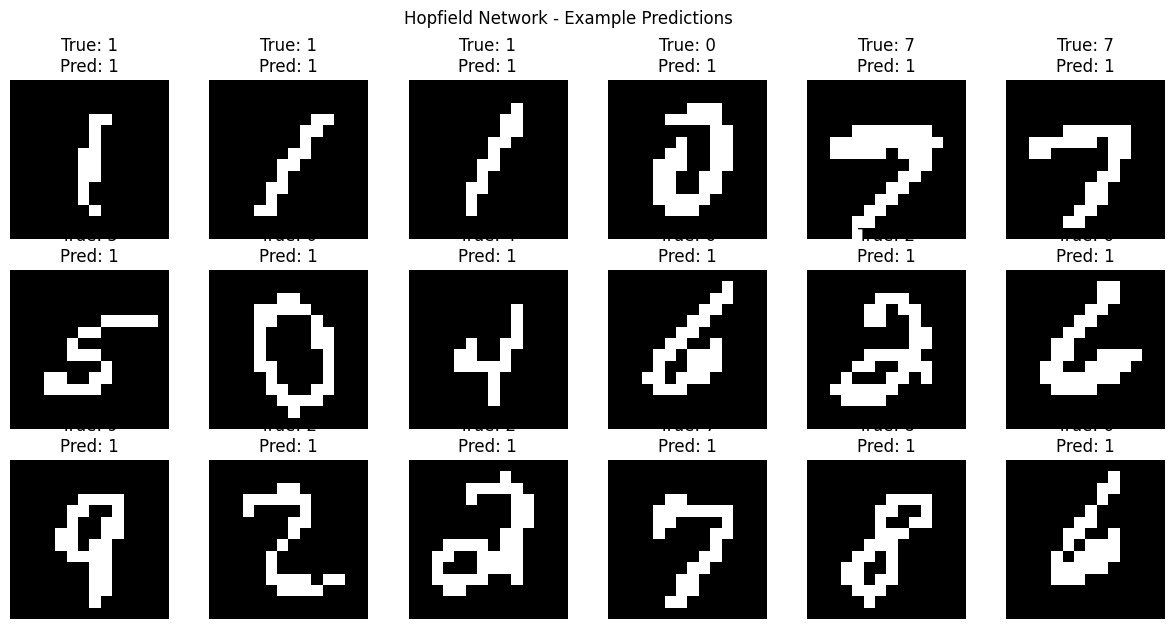

In [33]:
# Plot some example results
def plot_examples(patterns, labels, predicted_labels, model_name):
    fig, axes = plt.subplots(3, 6, figsize=(15, 7))
    for i in range(3):
        for j in range(6):
            idx = np.random.choice(range(len(patterns)))
            axes[i, j].imshow(patterns[idx], cmap='gray')
            title = f"True: {labels[idx]}\nPred: {predicted_labels[idx]}"
            axes[i, j].set_title(title)
            axes[i, j].axis('off')
    plt.suptitle(f'{model_name} - Example Predictions')
    plt.show()

plot_examples(test_patterns, test_labels, predicted_labels_hopfield, "Hopfield Network")

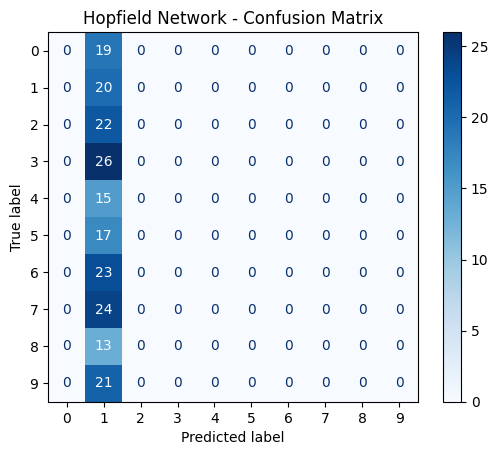

In [35]:
plot_confusion_matrix(test_labels, predicted_labels_hopfield, "Hopfield Network")

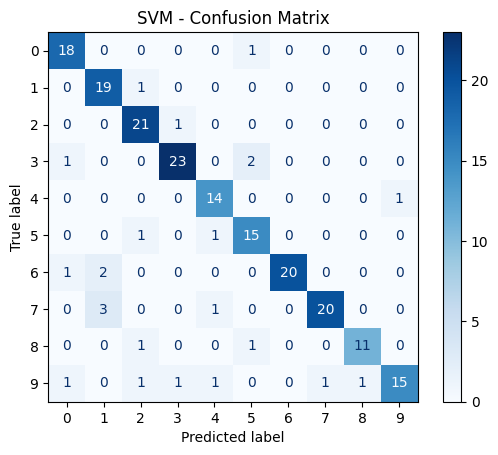

In [36]:
plot_confusion_matrix(test_labels, svm_predictions, "SVM")

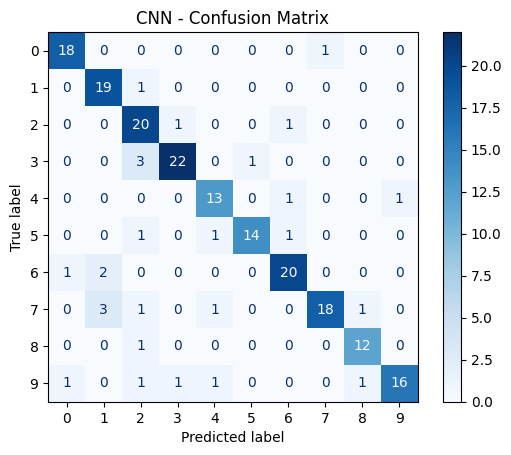

In [37]:
plot_confusion_matrix(test_labels, cnn_predictions_labels, "CNN")

# Merits

1. Hopfield networks are straight forward and easy to implement for small datasets.
2. They Perform well when we need to do pattern recognition from noisy inputs.


# Demerits

1. Hopfield networks become less effective when storing and retrieving large no. of patterns. Ex - MNIST
2. Deep Learning methods like CNN perform better than Hopfield network.